# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=80  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.0625), kernel_size=1, stride=1, padding=0, bias=False)
        
        #------------------------ 另一半 ----------------------------
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.9375), one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        # w=w[0]
        w=torch.randn(w[0].shape).cuda()*0.1
        a=torch.randn(1).cuda()*0.1
        if a>0.39:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel//2,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel//2,in_Channel]
        
        #-------------------------------------
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        
        if a>0.39:
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.301240, Accuracy: 11.33
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.334702, Accuracy: 10.94
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.352469, Accuracy: 10.16
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.375710, Accuracy: 10.16
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.334754, Accuracy: 11.72
Train Epoch: 0 [6400/50000 (14%)]	Loss: 2.414205, Accuracy: 10.16
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.347510, Accuracy: 12.89
Train Epoch: 0 [8960/50000 (20%)]	Loss: 2.342825, Accuracy: 11.33
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.381803, Accuracy: 11.33
Train Epoch: 0 [11520/50000 (26%)]	Loss: 2.361575, Accuracy: 12.89
Train Epoch: 0 [12800/50000 (28%)]	Loss: 2.389088, Accuracy: 13.28
Train Epoch: 0 [14080/50000 (31%)]	Loss: 2.361390, Accuracy: 13.28
Train Epoch: 0 [15360/50000 (34%)]	Loss: 2.387937, Accuracy: 11.72
Train Epoch: 0 [16640/50000 (37%)]	Loss: 2.341180, Accuracy: 14.84
Train Epoch: 0 [17920/50000 (40%)]	Loss: 2.298830, Accuracy: 14.45
Train Epoc

Train Epoch: 1 [17920/50000 (40%)]	Loss: 2.168350, Accuracy: 16.02
Train Epoch: 1 [19200/50000 (43%)]	Loss: 1.997069, Accuracy: 14.84
Train Epoch: 1 [20480/50000 (45%)]	Loss: 2.103459, Accuracy: 18.36
Train Epoch: 1 [21760/50000 (48%)]	Loss: 2.110861, Accuracy: 18.75
Train Epoch: 1 [23040/50000 (51%)]	Loss: 2.078086, Accuracy: 16.41
Train Epoch: 1 [24320/50000 (54%)]	Loss: 2.006876, Accuracy: 24.22
Train Epoch: 1 [25600/50000 (57%)]	Loss: 2.013635, Accuracy: 18.36
Train Epoch: 1 [26880/50000 (60%)]	Loss: 2.044418, Accuracy: 22.27
Train Epoch: 1 [28160/50000 (62%)]	Loss: 1.980558, Accuracy: 19.53
Train Epoch: 1 [29440/50000 (65%)]	Loss: 1.912832, Accuracy: 23.44
Train Epoch: 1 [30720/50000 (68%)]	Loss: 2.094183, Accuracy: 15.23
Train Epoch: 1 [32000/50000 (71%)]	Loss: 1.980727, Accuracy: 13.67
Train Epoch: 1 [33280/50000 (74%)]	Loss: 1.990576, Accuracy: 21.48
Train Epoch: 1 [34560/50000 (77%)]	Loss: 2.004022, Accuracy: 24.61
Train Epoch: 1 [35840/50000 (80%)]	Loss: 2.032838, Accuracy: 2

Train Epoch: 4 [30720/50000 (68%)]	Loss: 1.500151, Accuracy: 42.19
Train Epoch: 4 [32000/50000 (71%)]	Loss: 1.480334, Accuracy: 40.23
Train Epoch: 4 [33280/50000 (74%)]	Loss: 1.432675, Accuracy: 47.27
Train Epoch: 4 [34560/50000 (77%)]	Loss: 1.568970, Accuracy: 39.45
Train Epoch: 4 [35840/50000 (80%)]	Loss: 1.508436, Accuracy: 39.06
Train Epoch: 4 [37120/50000 (82%)]	Loss: 1.521852, Accuracy: 38.28
Train Epoch: 4 [38400/50000 (85%)]	Loss: 1.422558, Accuracy: 47.66
Train Epoch: 4 [39680/50000 (88%)]	Loss: 1.450338, Accuracy: 47.27
Train Epoch: 4 [40960/50000 (91%)]	Loss: 1.559019, Accuracy: 44.14
Train Epoch: 4 [42240/50000 (94%)]	Loss: 1.400855, Accuracy: 44.92
Train Epoch: 4 [43520/50000 (97%)]	Loss: 1.517008, Accuracy: 42.19
Train Epoch: 4 [35000/50000 (99%)]	Loss: 1.386753, Accuracy: 44.00

Validation set: Average loss: 1.6780, Accuracy: 2035/5000 (40.00%)

the time of this epoch:[36.007071018218994 s]
Train Epoch: 5 [0/50000 (0%)]	Loss: 1.419519, Accuracy: 46.88
Train Epoch: 5 [128

Train Epoch: 7 [43520/50000 (97%)]	Loss: 1.038463, Accuracy: 60.94
Train Epoch: 7 [35000/50000 (99%)]	Loss: 0.947029, Accuracy: 68.50

Validation set: Average loss: 1.0297, Accuracy: 3223/5000 (64.00%)

the time of this epoch:[35.971686601638794 s]
Train Epoch: 8 [0/50000 (0%)]	Loss: 0.974849, Accuracy: 63.67
Train Epoch: 8 [1280/50000 (3%)]	Loss: 1.037839, Accuracy: 65.23
Train Epoch: 8 [2560/50000 (6%)]	Loss: 0.834116, Accuracy: 67.97
Train Epoch: 8 [3840/50000 (9%)]	Loss: 0.997510, Accuracy: 65.62
Train Epoch: 8 [5120/50000 (11%)]	Loss: 0.924030, Accuracy: 66.02
Train Epoch: 8 [6400/50000 (14%)]	Loss: 1.010960, Accuracy: 69.14
Train Epoch: 8 [7680/50000 (17%)]	Loss: 0.885274, Accuracy: 71.48
Train Epoch: 8 [8960/50000 (20%)]	Loss: 0.934413, Accuracy: 68.75
Train Epoch: 8 [10240/50000 (23%)]	Loss: 0.832137, Accuracy: 72.27
Train Epoch: 8 [11520/50000 (26%)]	Loss: 0.883760, Accuracy: 71.88
Train Epoch: 8 [12800/50000 (28%)]	Loss: 0.862228, Accuracy: 69.92
Train Epoch: 8 [14080/50000 (

Train Epoch: 11 [6400/50000 (14%)]	Loss: 0.642221, Accuracy: 77.73
Train Epoch: 11 [7680/50000 (17%)]	Loss: 0.937101, Accuracy: 68.36
Train Epoch: 11 [8960/50000 (20%)]	Loss: 0.698529, Accuracy: 74.61
Train Epoch: 11 [10240/50000 (23%)]	Loss: 0.828336, Accuracy: 69.14
Train Epoch: 11 [11520/50000 (26%)]	Loss: 0.714435, Accuracy: 73.05
Train Epoch: 11 [12800/50000 (28%)]	Loss: 0.630951, Accuracy: 78.52
Train Epoch: 11 [14080/50000 (31%)]	Loss: 0.865763, Accuracy: 69.92
Train Epoch: 11 [15360/50000 (34%)]	Loss: 0.771422, Accuracy: 75.39
Train Epoch: 11 [16640/50000 (37%)]	Loss: 0.721475, Accuracy: 73.05
Train Epoch: 11 [17920/50000 (40%)]	Loss: 0.817617, Accuracy: 73.44
Train Epoch: 11 [19200/50000 (43%)]	Loss: 0.733912, Accuracy: 71.48
Train Epoch: 11 [20480/50000 (45%)]	Loss: 0.708301, Accuracy: 73.44
Train Epoch: 11 [21760/50000 (48%)]	Loss: 0.649074, Accuracy: 76.95
Train Epoch: 11 [23040/50000 (51%)]	Loss: 0.724603, Accuracy: 76.56
Train Epoch: 11 [24320/50000 (54%)]	Loss: 0.730722,

Train Epoch: 14 [16640/50000 (37%)]	Loss: 0.668779, Accuracy: 78.91
Train Epoch: 14 [17920/50000 (40%)]	Loss: 0.671836, Accuracy: 75.39
Train Epoch: 14 [19200/50000 (43%)]	Loss: 0.609941, Accuracy: 78.52
Train Epoch: 14 [20480/50000 (45%)]	Loss: 0.721135, Accuracy: 76.56
Train Epoch: 14 [21760/50000 (48%)]	Loss: 0.636990, Accuracy: 78.52
Train Epoch: 14 [23040/50000 (51%)]	Loss: 0.670981, Accuracy: 76.95
Train Epoch: 14 [24320/50000 (54%)]	Loss: 0.585684, Accuracy: 82.03
Train Epoch: 14 [25600/50000 (57%)]	Loss: 0.643851, Accuracy: 78.12
Train Epoch: 14 [26880/50000 (60%)]	Loss: 0.689252, Accuracy: 75.78
Train Epoch: 14 [28160/50000 (62%)]	Loss: 0.640156, Accuracy: 80.47
Train Epoch: 14 [29440/50000 (65%)]	Loss: 0.548955, Accuracy: 80.47
Train Epoch: 14 [30720/50000 (68%)]	Loss: 0.556170, Accuracy: 83.20
Train Epoch: 14 [32000/50000 (71%)]	Loss: 0.539532, Accuracy: 80.08
Train Epoch: 14 [33280/50000 (74%)]	Loss: 0.551073, Accuracy: 80.47
Train Epoch: 14 [34560/50000 (77%)]	Loss: 0.6689

Train Epoch: 17 [8960/50000 (20%)]	Loss: 0.655022, Accuracy: 78.12
Train Epoch: 17 [10240/50000 (23%)]	Loss: 0.475911, Accuracy: 83.98
Train Epoch: 17 [11520/50000 (26%)]	Loss: 0.436694, Accuracy: 85.16
Train Epoch: 17 [12800/50000 (28%)]	Loss: 0.536596, Accuracy: 81.64
Train Epoch: 17 [14080/50000 (31%)]	Loss: 0.557261, Accuracy: 82.42
Train Epoch: 17 [15360/50000 (34%)]	Loss: 0.526126, Accuracy: 80.86
Train Epoch: 17 [16640/50000 (37%)]	Loss: 0.603889, Accuracy: 79.69
Train Epoch: 17 [17920/50000 (40%)]	Loss: 0.535431, Accuracy: 80.86
Train Epoch: 17 [19200/50000 (43%)]	Loss: 0.500406, Accuracy: 83.98
Train Epoch: 17 [20480/50000 (45%)]	Loss: 0.572863, Accuracy: 80.08
Train Epoch: 17 [21760/50000 (48%)]	Loss: 0.652133, Accuracy: 77.73
Train Epoch: 17 [23040/50000 (51%)]	Loss: 0.563431, Accuracy: 78.91
Train Epoch: 17 [24320/50000 (54%)]	Loss: 0.592677, Accuracy: 79.30
Train Epoch: 17 [25600/50000 (57%)]	Loss: 0.478766, Accuracy: 82.81
Train Epoch: 17 [26880/50000 (60%)]	Loss: 0.48310

Train Epoch: 20 [19200/50000 (43%)]	Loss: 0.407768, Accuracy: 85.16
Train Epoch: 20 [20480/50000 (45%)]	Loss: 0.444591, Accuracy: 86.72
Train Epoch: 20 [21760/50000 (48%)]	Loss: 0.411173, Accuracy: 85.94
Train Epoch: 20 [23040/50000 (51%)]	Loss: 0.527043, Accuracy: 82.42
Train Epoch: 20 [24320/50000 (54%)]	Loss: 0.454235, Accuracy: 87.50
Train Epoch: 20 [25600/50000 (57%)]	Loss: 0.493340, Accuracy: 82.81
Train Epoch: 20 [26880/50000 (60%)]	Loss: 0.546995, Accuracy: 80.47
Train Epoch: 20 [28160/50000 (62%)]	Loss: 0.497543, Accuracy: 81.64
Train Epoch: 20 [29440/50000 (65%)]	Loss: 0.506653, Accuracy: 82.81
Train Epoch: 20 [30720/50000 (68%)]	Loss: 0.565866, Accuracy: 80.08
Train Epoch: 20 [32000/50000 (71%)]	Loss: 0.564969, Accuracy: 78.91
Train Epoch: 20 [33280/50000 (74%)]	Loss: 0.580548, Accuracy: 80.47
Train Epoch: 20 [34560/50000 (77%)]	Loss: 0.481179, Accuracy: 84.77
Train Epoch: 20 [35840/50000 (80%)]	Loss: 0.540349, Accuracy: 80.86
Train Epoch: 20 [37120/50000 (82%)]	Loss: 0.4448

Train Epoch: 23 [28160/50000 (62%)]	Loss: 0.446638, Accuracy: 87.11
Train Epoch: 23 [29440/50000 (65%)]	Loss: 0.499716, Accuracy: 82.42
Train Epoch: 23 [30720/50000 (68%)]	Loss: 0.464002, Accuracy: 83.20
Train Epoch: 23 [32000/50000 (71%)]	Loss: 0.474172, Accuracy: 83.98
Train Epoch: 23 [33280/50000 (74%)]	Loss: 0.451019, Accuracy: 84.77
Train Epoch: 23 [34560/50000 (77%)]	Loss: 0.405876, Accuracy: 87.50
Train Epoch: 23 [35840/50000 (80%)]	Loss: 0.527833, Accuracy: 81.25
Train Epoch: 23 [37120/50000 (82%)]	Loss: 0.572262, Accuracy: 80.47
Train Epoch: 23 [38400/50000 (85%)]	Loss: 0.454053, Accuracy: 86.72
Train Epoch: 23 [39680/50000 (88%)]	Loss: 0.580277, Accuracy: 80.47
Train Epoch: 23 [40960/50000 (91%)]	Loss: 0.590150, Accuracy: 78.91
Train Epoch: 23 [42240/50000 (94%)]	Loss: 0.454781, Accuracy: 85.16
Train Epoch: 23 [43520/50000 (97%)]	Loss: 0.400844, Accuracy: 85.55
Train Epoch: 23 [35000/50000 (99%)]	Loss: 0.582830, Accuracy: 80.00

Validation set: Average loss: 0.7563, Accuracy:

Train Epoch: 26 [33280/50000 (74%)]	Loss: 0.532896, Accuracy: 84.38
Train Epoch: 26 [34560/50000 (77%)]	Loss: 0.519782, Accuracy: 82.42
Train Epoch: 26 [35840/50000 (80%)]	Loss: 0.410541, Accuracy: 85.55
Train Epoch: 26 [37120/50000 (82%)]	Loss: 0.353001, Accuracy: 89.45
Train Epoch: 26 [38400/50000 (85%)]	Loss: 0.559184, Accuracy: 81.64
Train Epoch: 26 [39680/50000 (88%)]	Loss: 0.360188, Accuracy: 88.67
Train Epoch: 26 [40960/50000 (91%)]	Loss: 0.470854, Accuracy: 84.77
Train Epoch: 26 [42240/50000 (94%)]	Loss: 0.456592, Accuracy: 85.94
Train Epoch: 26 [43520/50000 (97%)]	Loss: 0.533914, Accuracy: 82.42
Train Epoch: 26 [35000/50000 (99%)]	Loss: 0.459594, Accuracy: 85.00

Validation set: Average loss: 0.8076, Accuracy: 3721/5000 (74.00%)

the time of this epoch:[36.08288526535034 s]

Test set: Average loss: 0.8052, Accuracy: 7401/10000 (74.01%)

Train Epoch: 27 [0/50000 (0%)]	Loss: 0.434210, Accuracy: 84.77
Train Epoch: 27 [1280/50000 (3%)]	Loss: 0.396654, Accuracy: 85.55
Train Epoch: 

Train Epoch: 29 [42240/50000 (94%)]	Loss: 0.546533, Accuracy: 82.81
Train Epoch: 29 [43520/50000 (97%)]	Loss: 0.393634, Accuracy: 87.50
Train Epoch: 29 [35000/50000 (99%)]	Loss: 0.408241, Accuracy: 87.00

Validation set: Average loss: 0.5950, Accuracy: 4003/5000 (80.00%)

the time of this epoch:[39.05315136909485 s]
Train Epoch: 30 [0/50000 (0%)]	Loss: 0.420914, Accuracy: 88.28
Train Epoch: 30 [1280/50000 (3%)]	Loss: 0.394626, Accuracy: 86.72
Train Epoch: 30 [2560/50000 (6%)]	Loss: 0.490723, Accuracy: 80.86
Train Epoch: 30 [3840/50000 (9%)]	Loss: 0.379958, Accuracy: 86.72
Train Epoch: 30 [5120/50000 (11%)]	Loss: 0.466074, Accuracy: 83.20
Train Epoch: 30 [6400/50000 (14%)]	Loss: 0.326736, Accuracy: 89.45
Train Epoch: 30 [7680/50000 (17%)]	Loss: 0.357665, Accuracy: 86.33
Train Epoch: 30 [8960/50000 (20%)]	Loss: 0.326984, Accuracy: 88.67
Train Epoch: 30 [10240/50000 (23%)]	Loss: 0.564250, Accuracy: 81.64
Train Epoch: 30 [11520/50000 (26%)]	Loss: 0.487632, Accuracy: 83.59
Train Epoch: 30 [

Train Epoch: 33 [2560/50000 (6%)]	Loss: 0.391473, Accuracy: 87.11
Train Epoch: 33 [3840/50000 (9%)]	Loss: 0.400050, Accuracy: 85.94
Train Epoch: 33 [5120/50000 (11%)]	Loss: 0.523285, Accuracy: 80.47
Train Epoch: 33 [6400/50000 (14%)]	Loss: 0.289456, Accuracy: 90.62
Train Epoch: 33 [7680/50000 (17%)]	Loss: 0.502945, Accuracy: 83.20
Train Epoch: 33 [8960/50000 (20%)]	Loss: 0.416561, Accuracy: 88.67
Train Epoch: 33 [10240/50000 (23%)]	Loss: 0.492184, Accuracy: 83.20
Train Epoch: 33 [11520/50000 (26%)]	Loss: 0.330891, Accuracy: 88.28
Train Epoch: 33 [12800/50000 (28%)]	Loss: 0.450138, Accuracy: 85.16
Train Epoch: 33 [14080/50000 (31%)]	Loss: 0.458600, Accuracy: 81.64
Train Epoch: 33 [15360/50000 (34%)]	Loss: 0.367945, Accuracy: 84.77
Train Epoch: 33 [16640/50000 (37%)]	Loss: 0.418991, Accuracy: 86.33
Train Epoch: 33 [17920/50000 (40%)]	Loss: 0.406255, Accuracy: 87.50
Train Epoch: 33 [19200/50000 (43%)]	Loss: 0.480646, Accuracy: 82.81
Train Epoch: 33 [20480/50000 (45%)]	Loss: 0.437511, Accu

Train Epoch: 36 [12800/50000 (28%)]	Loss: 0.405473, Accuracy: 84.77
Train Epoch: 36 [14080/50000 (31%)]	Loss: 0.474826, Accuracy: 82.81
Train Epoch: 36 [15360/50000 (34%)]	Loss: 0.424795, Accuracy: 86.72
Train Epoch: 36 [16640/50000 (37%)]	Loss: 0.363703, Accuracy: 87.89
Train Epoch: 36 [17920/50000 (40%)]	Loss: 0.373739, Accuracy: 88.67
Train Epoch: 36 [19200/50000 (43%)]	Loss: 0.327468, Accuracy: 87.89
Train Epoch: 36 [20480/50000 (45%)]	Loss: 0.461460, Accuracy: 82.81
Train Epoch: 36 [21760/50000 (48%)]	Loss: 0.423056, Accuracy: 87.11
Train Epoch: 36 [23040/50000 (51%)]	Loss: 0.363826, Accuracy: 88.67
Train Epoch: 36 [24320/50000 (54%)]	Loss: 0.373058, Accuracy: 86.33
Train Epoch: 36 [25600/50000 (57%)]	Loss: 0.450154, Accuracy: 85.94
Train Epoch: 36 [26880/50000 (60%)]	Loss: 0.536942, Accuracy: 82.81
Train Epoch: 36 [28160/50000 (62%)]	Loss: 0.481990, Accuracy: 83.59
Train Epoch: 36 [29440/50000 (65%)]	Loss: 0.529136, Accuracy: 83.59
Train Epoch: 36 [30720/50000 (68%)]	Loss: 0.4245

Train Epoch: 39 [21760/50000 (48%)]	Loss: 0.374355, Accuracy: 87.11
Train Epoch: 39 [23040/50000 (51%)]	Loss: 0.362673, Accuracy: 90.62
Train Epoch: 39 [24320/50000 (54%)]	Loss: 0.441523, Accuracy: 80.86
Train Epoch: 39 [25600/50000 (57%)]	Loss: 0.422791, Accuracy: 87.89
Train Epoch: 39 [26880/50000 (60%)]	Loss: 0.433153, Accuracy: 84.77
Train Epoch: 39 [28160/50000 (62%)]	Loss: 0.412199, Accuracy: 86.33
Train Epoch: 39 [29440/50000 (65%)]	Loss: 0.374744, Accuracy: 88.67
Train Epoch: 39 [30720/50000 (68%)]	Loss: 0.434489, Accuracy: 84.38
Train Epoch: 39 [32000/50000 (71%)]	Loss: 0.409439, Accuracy: 84.38
Train Epoch: 39 [33280/50000 (74%)]	Loss: 0.296048, Accuracy: 88.28
Train Epoch: 39 [34560/50000 (77%)]	Loss: 0.390883, Accuracy: 86.72
Train Epoch: 39 [35840/50000 (80%)]	Loss: 0.351117, Accuracy: 85.94
Train Epoch: 39 [37120/50000 (82%)]	Loss: 0.398580, Accuracy: 86.72
Train Epoch: 39 [38400/50000 (85%)]	Loss: 0.540696, Accuracy: 81.64
Train Epoch: 39 [39680/50000 (88%)]	Loss: 0.4087

Train Epoch: 42 [32000/50000 (71%)]	Loss: 0.337570, Accuracy: 89.45
Train Epoch: 42 [33280/50000 (74%)]	Loss: 0.385160, Accuracy: 88.67
Train Epoch: 42 [34560/50000 (77%)]	Loss: 0.422304, Accuracy: 87.11
Train Epoch: 42 [35840/50000 (80%)]	Loss: 0.398694, Accuracy: 84.38
Train Epoch: 42 [37120/50000 (82%)]	Loss: 0.279978, Accuracy: 90.62
Train Epoch: 42 [38400/50000 (85%)]	Loss: 0.300565, Accuracy: 89.84
Train Epoch: 42 [39680/50000 (88%)]	Loss: 0.351581, Accuracy: 86.72
Train Epoch: 42 [40960/50000 (91%)]	Loss: 0.459226, Accuracy: 84.77
Train Epoch: 42 [42240/50000 (94%)]	Loss: 0.464074, Accuracy: 83.59
Train Epoch: 42 [43520/50000 (97%)]	Loss: 0.325682, Accuracy: 89.06
Train Epoch: 42 [35000/50000 (99%)]	Loss: 0.480363, Accuracy: 83.50

Validation set: Average loss: 0.7732, Accuracy: 3824/5000 (76.00%)

the time of this epoch:[35.761536598205566 s]

Test set: Average loss: 0.7923, Accuracy: 7573/10000 (75.73%)

Train Epoch: 43 [0/50000 (0%)]	Loss: 0.439000, Accuracy: 85.94
Train Epoc

Train Epoch: 45 [40960/50000 (91%)]	Loss: 0.438031, Accuracy: 84.38
Train Epoch: 45 [42240/50000 (94%)]	Loss: 0.454226, Accuracy: 85.16
Train Epoch: 45 [43520/50000 (97%)]	Loss: 0.424823, Accuracy: 85.55
Train Epoch: 45 [35000/50000 (99%)]	Loss: 0.386307, Accuracy: 88.00

Validation set: Average loss: 0.6744, Accuracy: 3924/5000 (78.00%)

the time of this epoch:[38.880345821380615 s]
Train Epoch: 46 [0/50000 (0%)]	Loss: 0.472081, Accuracy: 85.16
Train Epoch: 46 [1280/50000 (3%)]	Loss: 0.448421, Accuracy: 84.38
Train Epoch: 46 [2560/50000 (6%)]	Loss: 0.417293, Accuracy: 86.72
Train Epoch: 46 [3840/50000 (9%)]	Loss: 0.418352, Accuracy: 86.33
Train Epoch: 46 [5120/50000 (11%)]	Loss: 0.466425, Accuracy: 83.59
Train Epoch: 46 [6400/50000 (14%)]	Loss: 0.387830, Accuracy: 85.94
Train Epoch: 46 [7680/50000 (17%)]	Loss: 0.544395, Accuracy: 81.25
Train Epoch: 46 [8960/50000 (20%)]	Loss: 0.343998, Accuracy: 89.06
Train Epoch: 46 [10240/50000 (23%)]	Loss: 0.370913, Accuracy: 87.11
Train Epoch: 46 

Train Epoch: 49 [1280/50000 (3%)]	Loss: 0.373948, Accuracy: 87.11
Train Epoch: 49 [2560/50000 (6%)]	Loss: 0.349459, Accuracy: 88.28
Train Epoch: 49 [3840/50000 (9%)]	Loss: 0.450567, Accuracy: 84.38
Train Epoch: 49 [5120/50000 (11%)]	Loss: 0.409680, Accuracy: 85.55
Train Epoch: 49 [6400/50000 (14%)]	Loss: 0.412083, Accuracy: 87.89
Train Epoch: 49 [7680/50000 (17%)]	Loss: 0.444649, Accuracy: 85.55
Train Epoch: 49 [8960/50000 (20%)]	Loss: 0.381606, Accuracy: 85.16
Train Epoch: 49 [10240/50000 (23%)]	Loss: 0.310850, Accuracy: 89.45
Train Epoch: 49 [11520/50000 (26%)]	Loss: 0.383872, Accuracy: 88.67
Train Epoch: 49 [12800/50000 (28%)]	Loss: 0.348942, Accuracy: 86.72
Train Epoch: 49 [14080/50000 (31%)]	Loss: 0.366382, Accuracy: 85.94
Train Epoch: 49 [15360/50000 (34%)]	Loss: 0.408395, Accuracy: 84.77
Train Epoch: 49 [16640/50000 (37%)]	Loss: 0.383141, Accuracy: 87.50
Train Epoch: 49 [17920/50000 (40%)]	Loss: 0.333070, Accuracy: 87.50
Train Epoch: 49 [19200/50000 (43%)]	Loss: 0.427330, Accura

Train Epoch: 52 [11520/50000 (26%)]	Loss: 0.189331, Accuracy: 94.14
Train Epoch: 52 [12800/50000 (28%)]	Loss: 0.269368, Accuracy: 89.06
Train Epoch: 52 [14080/50000 (31%)]	Loss: 0.200588, Accuracy: 94.14
Train Epoch: 52 [15360/50000 (34%)]	Loss: 0.244946, Accuracy: 90.23
Train Epoch: 52 [16640/50000 (37%)]	Loss: 0.203417, Accuracy: 91.41
Train Epoch: 52 [17920/50000 (40%)]	Loss: 0.222663, Accuracy: 92.58
Train Epoch: 52 [19200/50000 (43%)]	Loss: 0.277221, Accuracy: 89.84
Train Epoch: 52 [20480/50000 (45%)]	Loss: 0.200576, Accuracy: 92.19
Train Epoch: 52 [21760/50000 (48%)]	Loss: 0.203676, Accuracy: 92.58
Train Epoch: 52 [23040/50000 (51%)]	Loss: 0.215982, Accuracy: 93.36
Train Epoch: 52 [24320/50000 (54%)]	Loss: 0.189082, Accuracy: 93.75
Train Epoch: 52 [25600/50000 (57%)]	Loss: 0.190721, Accuracy: 92.97
Train Epoch: 52 [26880/50000 (60%)]	Loss: 0.169350, Accuracy: 93.75
Train Epoch: 52 [28160/50000 (62%)]	Loss: 0.250329, Accuracy: 92.58
Train Epoch: 52 [29440/50000 (65%)]	Loss: 0.2269

Train Epoch: 55 [20480/50000 (45%)]	Loss: 0.186171, Accuracy: 94.14
Train Epoch: 55 [21760/50000 (48%)]	Loss: 0.190197, Accuracy: 93.75
Train Epoch: 55 [23040/50000 (51%)]	Loss: 0.167916, Accuracy: 93.36
Train Epoch: 55 [24320/50000 (54%)]	Loss: 0.193222, Accuracy: 93.36
Train Epoch: 55 [25600/50000 (57%)]	Loss: 0.139558, Accuracy: 94.92
Train Epoch: 55 [26880/50000 (60%)]	Loss: 0.137685, Accuracy: 95.31
Train Epoch: 55 [28160/50000 (62%)]	Loss: 0.122898, Accuracy: 96.09
Train Epoch: 55 [29440/50000 (65%)]	Loss: 0.136245, Accuracy: 96.48
Train Epoch: 55 [30720/50000 (68%)]	Loss: 0.195593, Accuracy: 93.36
Train Epoch: 55 [32000/50000 (71%)]	Loss: 0.162349, Accuracy: 94.53
Train Epoch: 55 [33280/50000 (74%)]	Loss: 0.107483, Accuracy: 96.48
Train Epoch: 55 [34560/50000 (77%)]	Loss: 0.188390, Accuracy: 93.36
Train Epoch: 55 [35840/50000 (80%)]	Loss: 0.180222, Accuracy: 94.14
Train Epoch: 55 [37120/50000 (82%)]	Loss: 0.138282, Accuracy: 95.31
Train Epoch: 55 [38400/50000 (85%)]	Loss: 0.1645

Train Epoch: 58 [30720/50000 (68%)]	Loss: 0.165196, Accuracy: 94.14
Train Epoch: 58 [32000/50000 (71%)]	Loss: 0.185827, Accuracy: 93.36
Train Epoch: 58 [33280/50000 (74%)]	Loss: 0.121982, Accuracy: 95.70
Train Epoch: 58 [34560/50000 (77%)]	Loss: 0.092098, Accuracy: 96.48
Train Epoch: 58 [35840/50000 (80%)]	Loss: 0.164523, Accuracy: 94.14
Train Epoch: 58 [37120/50000 (82%)]	Loss: 0.102245, Accuracy: 96.88
Train Epoch: 58 [38400/50000 (85%)]	Loss: 0.148909, Accuracy: 94.14
Train Epoch: 58 [39680/50000 (88%)]	Loss: 0.150873, Accuracy: 95.70
Train Epoch: 58 [40960/50000 (91%)]	Loss: 0.169070, Accuracy: 94.14
Train Epoch: 58 [42240/50000 (94%)]	Loss: 0.129417, Accuracy: 96.09
Train Epoch: 58 [43520/50000 (97%)]	Loss: 0.199169, Accuracy: 94.14
Train Epoch: 58 [35000/50000 (99%)]	Loss: 0.149100, Accuracy: 96.50

Validation set: Average loss: 0.2895, Accuracy: 4537/5000 (90.00%)

the time of this epoch:[35.71143865585327 s]

Test set: Average loss: 0.2989, Accuracy: 9079/10000 (90.79%)

Train 

Train Epoch: 61 [39680/50000 (88%)]	Loss: 0.112138, Accuracy: 95.70
Train Epoch: 61 [40960/50000 (91%)]	Loss: 0.130470, Accuracy: 95.31
Train Epoch: 61 [42240/50000 (94%)]	Loss: 0.157277, Accuracy: 96.09
Train Epoch: 61 [43520/50000 (97%)]	Loss: 0.129461, Accuracy: 94.92
Train Epoch: 61 [35000/50000 (99%)]	Loss: 0.108757, Accuracy: 96.00

Validation set: Average loss: 0.2858, Accuracy: 4561/5000 (91.00%)

the time of this epoch:[38.84687113761902 s]
Train Epoch: 62 [0/50000 (0%)]	Loss: 0.165017, Accuracy: 94.14
Train Epoch: 62 [1280/50000 (3%)]	Loss: 0.125211, Accuracy: 95.31
Train Epoch: 62 [2560/50000 (6%)]	Loss: 0.138980, Accuracy: 94.53
Train Epoch: 62 [3840/50000 (9%)]	Loss: 0.104258, Accuracy: 94.92
Train Epoch: 62 [5120/50000 (11%)]	Loss: 0.127583, Accuracy: 94.53
Train Epoch: 62 [6400/50000 (14%)]	Loss: 0.159826, Accuracy: 95.31
Train Epoch: 62 [7680/50000 (17%)]	Loss: 0.105759, Accuracy: 95.31
Train Epoch: 62 [8960/50000 (20%)]	Loss: 0.135305, Accuracy: 95.31
Train Epoch: 62 [

Train Epoch: 65 [1280/50000 (3%)]	Loss: 0.072003, Accuracy: 98.83
Train Epoch: 65 [2560/50000 (6%)]	Loss: 0.139745, Accuracy: 95.70
Train Epoch: 65 [3840/50000 (9%)]	Loss: 0.108051, Accuracy: 95.31
Train Epoch: 65 [5120/50000 (11%)]	Loss: 0.121767, Accuracy: 96.48
Train Epoch: 65 [6400/50000 (14%)]	Loss: 0.088294, Accuracy: 97.66
Train Epoch: 65 [7680/50000 (17%)]	Loss: 0.099773, Accuracy: 97.66
Train Epoch: 65 [8960/50000 (20%)]	Loss: 0.098998, Accuracy: 97.27
Train Epoch: 65 [10240/50000 (23%)]	Loss: 0.119183, Accuracy: 96.88
Train Epoch: 65 [11520/50000 (26%)]	Loss: 0.086633, Accuracy: 97.27
Train Epoch: 65 [12800/50000 (28%)]	Loss: 0.154402, Accuracy: 94.92
Train Epoch: 65 [14080/50000 (31%)]	Loss: 0.191456, Accuracy: 94.53
Train Epoch: 65 [15360/50000 (34%)]	Loss: 0.108553, Accuracy: 95.70
Train Epoch: 65 [16640/50000 (37%)]	Loss: 0.117099, Accuracy: 97.27
Train Epoch: 65 [17920/50000 (40%)]	Loss: 0.091600, Accuracy: 96.48
Train Epoch: 65 [19200/50000 (43%)]	Loss: 0.094180, Accura

Train Epoch: 67 [11520/50000 (26%)]	Loss: 0.088882, Accuracy: 97.66
Train Epoch: 67 [12800/50000 (28%)]	Loss: 0.108618, Accuracy: 96.88
Train Epoch: 67 [14080/50000 (31%)]	Loss: 0.130832, Accuracy: 96.09
Train Epoch: 67 [15360/50000 (34%)]	Loss: 0.078304, Accuracy: 98.05
Train Epoch: 67 [16640/50000 (37%)]	Loss: 0.091857, Accuracy: 97.66
Train Epoch: 67 [17920/50000 (40%)]	Loss: 0.075383, Accuracy: 97.27
Train Epoch: 67 [19200/50000 (43%)]	Loss: 0.098925, Accuracy: 96.09
Train Epoch: 67 [20480/50000 (45%)]	Loss: 0.093764, Accuracy: 96.88
Train Epoch: 67 [21760/50000 (48%)]	Loss: 0.147460, Accuracy: 94.53
Train Epoch: 67 [23040/50000 (51%)]	Loss: 0.087602, Accuracy: 97.27
Train Epoch: 67 [24320/50000 (54%)]	Loss: 0.108724, Accuracy: 97.66
Train Epoch: 67 [25600/50000 (57%)]	Loss: 0.086593, Accuracy: 96.88
Train Epoch: 67 [26880/50000 (60%)]	Loss: 0.137764, Accuracy: 95.70
Train Epoch: 67 [28160/50000 (62%)]	Loss: 0.085961, Accuracy: 96.88
Train Epoch: 67 [29440/50000 (65%)]	Loss: 0.1079


Validation set: Average loss: 0.3362, Accuracy: 4519/5000 (90.00%)

the time of this epoch:[35.7597770690918 s]

Test set: Average loss: 0.3416, Accuracy: 9028/10000 (90.28%)

Train Epoch: 69 [0/50000 (0%)]	Loss: 0.139030, Accuracy: 94.53
Train Epoch: 69 [1280/50000 (3%)]	Loss: 0.097228, Accuracy: 95.70
Train Epoch: 69 [2560/50000 (6%)]	Loss: 0.096271, Accuracy: 97.66
Train Epoch: 69 [3840/50000 (9%)]	Loss: 0.088954, Accuracy: 96.09
Train Epoch: 69 [5120/50000 (11%)]	Loss: 0.098018, Accuracy: 96.48
Train Epoch: 69 [6400/50000 (14%)]	Loss: 0.037827, Accuracy: 99.61
Train Epoch: 69 [7680/50000 (17%)]	Loss: 0.092986, Accuracy: 96.48
Train Epoch: 69 [8960/50000 (20%)]	Loss: 0.094795, Accuracy: 96.88
Train Epoch: 69 [10240/50000 (23%)]	Loss: 0.140214, Accuracy: 96.09
Train Epoch: 69 [11520/50000 (26%)]	Loss: 0.067706, Accuracy: 97.66
Train Epoch: 69 [12800/50000 (28%)]	Loss: 0.064262, Accuracy: 98.83
Train Epoch: 69 [14080/50000 (31%)]	Loss: 0.102442, Accuracy: 97.66
Train Epoch: 69 [15360

Train Epoch: 72 [6400/50000 (14%)]	Loss: 0.037989, Accuracy: 98.83
Train Epoch: 72 [7680/50000 (17%)]	Loss: 0.071077, Accuracy: 97.66
Train Epoch: 72 [8960/50000 (20%)]	Loss: 0.060479, Accuracy: 97.27
Train Epoch: 72 [10240/50000 (23%)]	Loss: 0.039021, Accuracy: 98.44
Train Epoch: 72 [11520/50000 (26%)]	Loss: 0.101255, Accuracy: 96.88
Train Epoch: 72 [12800/50000 (28%)]	Loss: 0.035476, Accuracy: 99.61
Train Epoch: 72 [14080/50000 (31%)]	Loss: 0.069264, Accuracy: 97.66
Train Epoch: 72 [15360/50000 (34%)]	Loss: 0.056141, Accuracy: 98.05
Train Epoch: 72 [16640/50000 (37%)]	Loss: 0.092740, Accuracy: 96.88
Train Epoch: 72 [17920/50000 (40%)]	Loss: 0.059587, Accuracy: 98.83
Train Epoch: 72 [19200/50000 (43%)]	Loss: 0.073347, Accuracy: 97.27
Train Epoch: 72 [20480/50000 (45%)]	Loss: 0.076045, Accuracy: 96.88
Train Epoch: 72 [21760/50000 (48%)]	Loss: 0.030979, Accuracy: 98.83
Train Epoch: 72 [23040/50000 (51%)]	Loss: 0.075575, Accuracy: 98.05
Train Epoch: 72 [24320/50000 (54%)]	Loss: 0.043026,

Train Epoch: 75 [15360/50000 (34%)]	Loss: 0.040556, Accuracy: 98.44
Train Epoch: 75 [16640/50000 (37%)]	Loss: 0.077453, Accuracy: 97.27
Train Epoch: 75 [17920/50000 (40%)]	Loss: 0.074946, Accuracy: 98.05
Train Epoch: 75 [19200/50000 (43%)]	Loss: 0.076048, Accuracy: 97.66
Train Epoch: 75 [20480/50000 (45%)]	Loss: 0.034777, Accuracy: 99.22
Train Epoch: 75 [21760/50000 (48%)]	Loss: 0.072239, Accuracy: 97.66
Train Epoch: 75 [23040/50000 (51%)]	Loss: 0.061372, Accuracy: 98.05
Train Epoch: 75 [24320/50000 (54%)]	Loss: 0.109586, Accuracy: 96.09
Train Epoch: 75 [25600/50000 (57%)]	Loss: 0.046464, Accuracy: 98.83
Train Epoch: 75 [26880/50000 (60%)]	Loss: 0.057330, Accuracy: 98.05
Train Epoch: 75 [28160/50000 (62%)]	Loss: 0.038195, Accuracy: 98.83
Train Epoch: 75 [29440/50000 (65%)]	Loss: 0.062613, Accuracy: 97.66
Train Epoch: 75 [30720/50000 (68%)]	Loss: 0.035486, Accuracy: 98.83
Train Epoch: 75 [32000/50000 (71%)]	Loss: 0.062646, Accuracy: 98.05
Train Epoch: 75 [33280/50000 (74%)]	Loss: 0.0638

Train Epoch: 78 [25600/50000 (57%)]	Loss: 0.028082, Accuracy: 98.83
Train Epoch: 78 [26880/50000 (60%)]	Loss: 0.065132, Accuracy: 97.66
Train Epoch: 78 [28160/50000 (62%)]	Loss: 0.054980, Accuracy: 97.66
Train Epoch: 78 [29440/50000 (65%)]	Loss: 0.040026, Accuracy: 98.83
Train Epoch: 78 [30720/50000 (68%)]	Loss: 0.037681, Accuracy: 98.83
Train Epoch: 78 [32000/50000 (71%)]	Loss: 0.067051, Accuracy: 98.05
Train Epoch: 78 [33280/50000 (74%)]	Loss: 0.082519, Accuracy: 97.27
Train Epoch: 78 [34560/50000 (77%)]	Loss: 0.033014, Accuracy: 99.22
Train Epoch: 78 [35840/50000 (80%)]	Loss: 0.070445, Accuracy: 97.66
Train Epoch: 78 [37120/50000 (82%)]	Loss: 0.040863, Accuracy: 98.44
Train Epoch: 78 [38400/50000 (85%)]	Loss: 0.052948, Accuracy: 98.83
Train Epoch: 78 [39680/50000 (88%)]	Loss: 0.029969, Accuracy: 99.22
Train Epoch: 78 [40960/50000 (91%)]	Loss: 0.072944, Accuracy: 98.05
Train Epoch: 78 [42240/50000 (94%)]	Loss: 0.053421, Accuracy: 98.44
Train Epoch: 78 [43520/50000 (97%)]	Loss: 0.0583

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

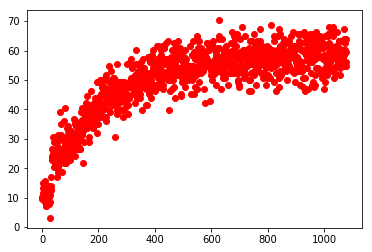

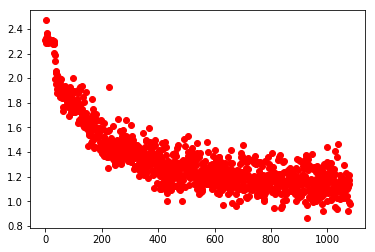

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

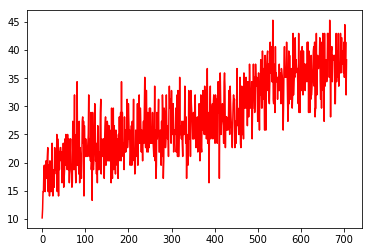

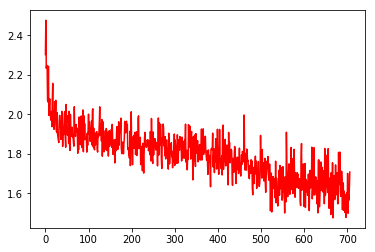

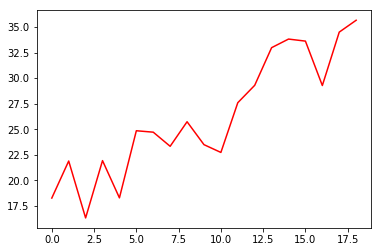

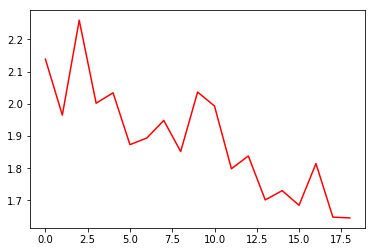

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()